# Featrue Importance (KampVoter)

## Import Library

### Basic Libary

In [1]:
from kamp.preprocess import KampDataLoader
from kamp.models import KampVoter

from sklearn.model_selection import RandomizedSearchCV

### Models

In [2]:
# Boosting Models
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

## Data Load

In [3]:
DATA_PATH = './data/경진대회용 주조 공정최적화 데이터셋.csv'


data_loader = KampDataLoader(
    path = DATA_PATH,

    # 처리 안한게 더 좋았음
    # 처리 안한 것 : 0.944
    # 처리 한 것 : 최대 0.922
    do_count_trend=False,
    drop_count=False,

    get_useful_p_data=True,
    p_threshold=0.05,

    outlier_method='iso',
    iso_outlier_rate=0.0075,

    do_resample=False,
    # downsampled_pass_rate=1.0,
    # upsampled_fail_rate_about_pass=0.10,
    # upsample_method='adasyn',

    scale_include_cat=False
)

data_loader.process()

data = data_loader.load()

x_train = data['train_data']
y_train = data['train_label']
x_test = data['test_data']
y_test=  data['test_label']

==================== [Data Process Start] ==================== 

[Process Log] Loading Raw Data...
[Process Log] Done

[Process Log] Processing Nan Value...
[Process Log] Done

[Process Log] Encoding Categorical Features...
[Process Log] Done

[Process Log] Removing Outliers (IsoForest)...
[Outlier-Remover Log] With Outliers Shape : (89753, 23)
[Outlier-Remover Log] Without Outliers Shape : (89079, 23)
[Process Log] Done

[Process Log] T-Testing...
[Process Log] Done

[Process Log] Data Scaling (MinMaxScaler)...
[Process Log] Done

[Process Log] Train Test Spliting...
[Process Log] Done

======================= [Done] =======================


## Modeling

### Best Version

```python
voting_models = {
    'catboost' : best_catboost,
    'lgbm' : best_lgbm,
    'xgb' : best_xgb,
}

model_weights = [1.5,1,1]

kamp_voter = KampVoter(voting_models=voting_models,
                       model_weights=model_weights, 
                       voting_method='soft')
```

```python
"-----------------------------------------------------------"
f1_score : 0.9614791987673343

confusion matrix : 
[[17142    18]
 [   32   624]]

classification report : 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17160
         1.0       0.97      0.95      0.96       656

    accuracy                           1.00     17816
   macro avg       0.99      0.98      0.98     17816
weighted avg       1.00      1.00      1.00     17816
```

### Base Model Tuning

#### CatBoostClassifier

In [4]:
cat_param_grid = {
    'iterations' : [1000, 1500],
    'learning_rate' : [0.01, 0.03, 0.05],
    'depth' : [4, 6],
    'l2_leaf_reg' : [1, 3, 5],
    'random_seed' : [42],
    'verbose' : [0]
}

random_search = RandomizedSearchCV(
    estimator = CatBoostClassifier(),
    param_distributions = cat_param_grid,
    n_iter = 20,
    cv = 3,
    verbose = 2,
    random_state = 42,
    n_jobs = -1
)

random_search.fit(x_train, y_train)

print(f"Best HyperParameters : {random_search.best_params_}")

best_catboost = random_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best HyperParameters : {'verbose': 0, 'random_seed': 42, 'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 1500, 'depth': 6}


#### LGBMClassifier

In [5]:
# 2m 20s
lgbm_param_grid = {
    'boosting_type' : ['gbdt', 'dart'],
    # 'n_estimators' : [100, 150, 200, 250],
    'learning_rate' : [0.01, 0.1, 0.5],
    'max_depth' : [-1],
    'random_state' : [42],
    'verbose' : [0]
}

random_search = RandomizedSearchCV(
    estimator = LGBMClassifier(),
    param_distributions = lgbm_param_grid,
    n_iter = 30,
    cv = 3,
    verbose = 2,
    random_state = 42,
    n_jobs = -1
)

random_search.fit(x_train, y_train)

print(f"Best HyperParameters : {random_search.best_params_}")

best_lgbm = random_search.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\USER\anaconda3\envs\kamp_competition\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=30. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best HyperParameters : {'verbose': 0, 'random_state': 42, 'max_depth': -1, 'learning_rate': 0.1, 'boosting_type': 'gbdt'}


#### XGBClassifier

In [6]:
xgb_param_grid = {
    # 'booster' : ['gbtree'],
    'n_estimators' : [100, 150, 200],
    'learning_rate' : [0.1, 0.3, 0.5],
    'max_depth' : [10, 12, 14, 16],
    'random_state' : [42],
    'verbosity' : [0]
}

random_search = RandomizedSearchCV(
    estimator = XGBClassifier(),
    param_distributions = xgb_param_grid,
    n_iter = 30,
    cv = 3,
    verbose = 2,
    random_state = 42,
    n_jobs = -1
)

random_search.fit(x_train, y_train)

print(f"Best HyperParameters : {random_search.best_params_}")

best_xgb = random_search.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best HyperParameters : {'verbosity': 0, 'random_state': 42, 'n_estimators': 200, 'max_depth': 16, 'learning_rate': 0.3}


### Voting Model Tuning

In [31]:
voting_models = {
    'catboost' : best_catboost,
    'lgbm' : best_lgbm,
    'xgb' : best_xgb,
}

# model_weights = [1.5,
#                  1.0,
#                  1.0]

model_weights = [5.0,
                 1.8,
                 1.0]

kamp_voter = KampVoter(voting_models = voting_models,
                       model_weights = model_weights, 
                       voting_method = 'soft')

In [32]:
kamp_voter.fit(x_train, y_train)

[Voting] ................. (1 of 3) Processing catboost, total=  12.9s
[Voting] ..................... (2 of 3) Processing lgbm, total=   0.2s
[Voting] ...................... (3 of 3) Processing xgb, total=   0.5s


VotingClassifier(estimators=[('catboost',
                              <catboost.core.CatBoostClassifier object at 0x000002555420ACB0>),
                             ('lgbm',
                              LGBMClassifier(random_state=42, verbose=0)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,...
                                            interaction_constraints=None,
                                            learning_rate=0.3, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=16,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 verbose=1, voting='soft', weights=[5.0, 1.8, 1.0])

## Evaluation

In [33]:
kamp_voter.evaluate(x_train, y_train)

f1_score : 0.9934587080948487

confusion matrix : 
[[64347     3]
 [   29  2430]]

classification report : 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     64350
         1.0       1.00      0.99      0.99      2459

    accuracy                           1.00     66809
   macro avg       1.00      0.99      1.00     66809
weighted avg       1.00      1.00      1.00     66809




In [34]:
kamp_voter.evaluate(x_test, y_test)

f1_score : 0.9591584158415841

confusion matrix : 
[[21429    21]
 [   45   775]]

classification report : 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     21450
         1.0       0.97      0.95      0.96       820

    accuracy                           1.00     22270
   macro avg       0.99      0.97      0.98     22270
weighted avg       1.00      1.00      1.00     22270




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance


# Permutation Importance 사용
perm_importance = permutation_importance(kamp_voter.voting_classifier, x_test, y_test, n_repeats=30, random_state=42)

sorted_indices_perm = np.argsort(perm_importance.importances_mean)

# 4. 시각화
feature_names = x_test.columns.tolist()
plt.figure(figsize=(12, 6))
# plt.barh(x_test.columns.tolist(), perm_importance.importances_mean, align='center', label='Permutation Importance', color='orange', alpha=0.6)
plt.barh(np.array(feature_names)[sorted_indices_perm], perm_importance.importances_mean[sorted_indices_perm], 
         align='center', label='Permutation Importance', color='orange', alpha=0.6)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.legend()
plt.show()

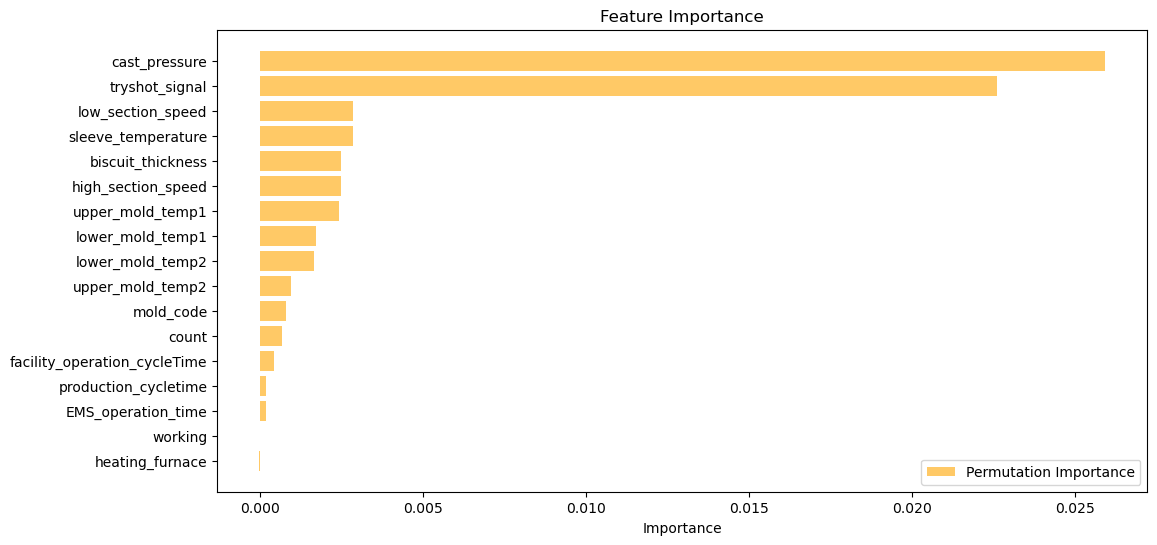

In [ ]:

# Permutation Importance 사용
perm_importance = permutation_importance(best_catboost, x_test, y_test, n_repeats=30, random_state=42)

sorted_indices_perm = np.argsort(perm_importance.importances_mean)

# 4. 시각화
feature_names = x_test.columns.tolist()
plt.figure(figsize=(12, 6))
# plt.barh(x_test.columns.tolist(), perm_importance.importances_mean, align='center', label='Permutation Importance', color='orange', alpha=0.6)
plt.barh(np.array(feature_names)[sorted_indices_perm], perm_importance.importances_mean[sorted_indices_perm], 
         align='center', label='Permutation Importance', color='orange', alpha=0.6)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.legend()
plt.show()

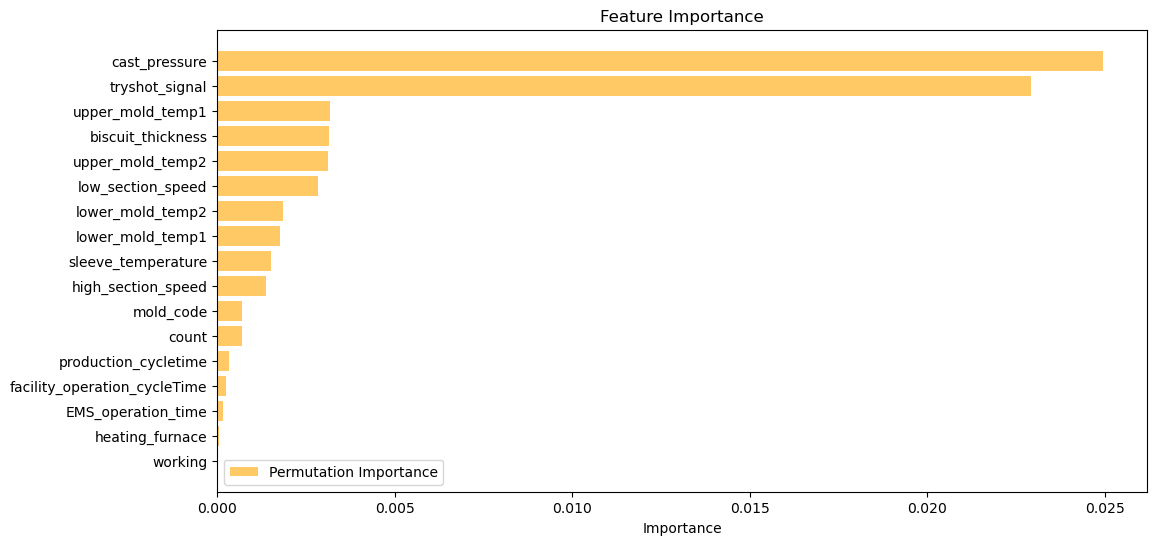

In [ ]:

# Permutation Importance 사용
perm_importance = permutation_importance(best_lgbm, x_test, y_test, n_repeats=30, random_state=42)

sorted_indices_perm = np.argsort(perm_importance.importances_mean)

# 4. 시각화
feature_names = x_test.columns.tolist()
plt.figure(figsize=(12, 6))
# plt.barh(x_test.columns.tolist(), perm_importance.importances_mean, align='center', label='Permutation Importance', color='orange', alpha=0.6)
plt.barh(np.array(feature_names)[sorted_indices_perm], perm_importance.importances_mean[sorted_indices_perm], 
         align='center', label='Permutation Importance', color='orange', alpha=0.6)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.legend()
plt.show()

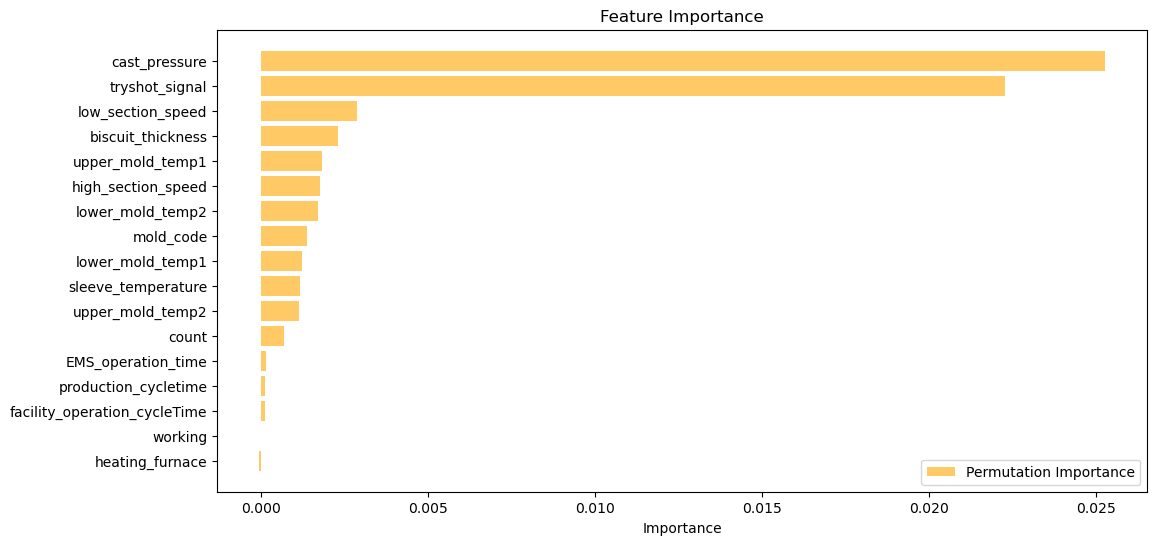

In [ ]:

# Permutation Importance 사용
perm_importance = permutation_importance(best_xgb, x_test, y_test, n_repeats=30, random_state=42)

sorted_indices_perm = np.argsort(perm_importance.importances_mean)

# 4. 시각화
feature_names = x_test.columns.tolist()
plt.figure(figsize=(12, 6))
# plt.barh(x_test.columns.tolist(), perm_importance.importances_mean, align='center', label='Permutation Importance', color='orange', alpha=0.6)
plt.barh(np.array(feature_names)[sorted_indices_perm], perm_importance.importances_mean[sorted_indices_perm], 
         align='center', label='Permutation Importance', color='orange', alpha=0.6)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.legend()
plt.show()